## STREETVIEW HOUSE NUMBERS DATA PROCESSING USING NEURAL NETWORKS




---



---



# Download Datasets from Standforf for training and test

In [62]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat

--2020-01-19 09:42:11--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.1’

train_32x32.mat.1   100%[===================>] 173.61M  17.1MB/s    in 10s     

2020-01-19 09:42:21 (17.0 MB/s) - ‘train_32x32.mat.1’ saved [182040794/182040794]



In [63]:
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-01-19 09:42:23--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.1’

test_32x32.mat.1    100%[===================>]  61.30M  17.7MB/s    in 3.9s    

2020-01-19 09:42:27 (15.7 MB/s) - ‘test_32x32.mat.1’ saved [64275384/64275384]



# Preprocessing the 32 x 32 image datset

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

# Loading the data by reading the .MAT files

In [65]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


#Transposing the the train and test data by converting it from  (width, height, channels, size) -> (size, width, height, channels)

In [66]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 99289


# Plotting Function for fig in n rows X m columns can be used for grayscale and RGB both

In [0]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

# Plot some of the training images

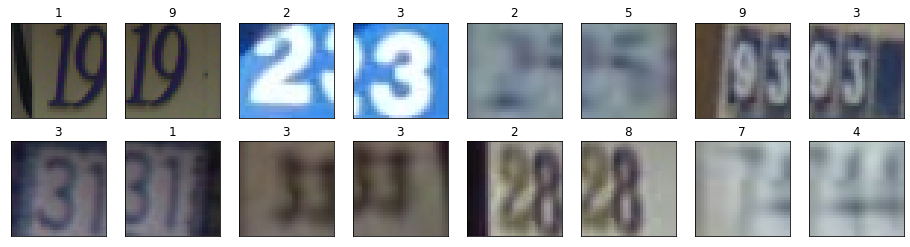

In [68]:
# Plot some training set images
plot_images(X_train, y_train, 2, 8)

# Plot some of testing set images

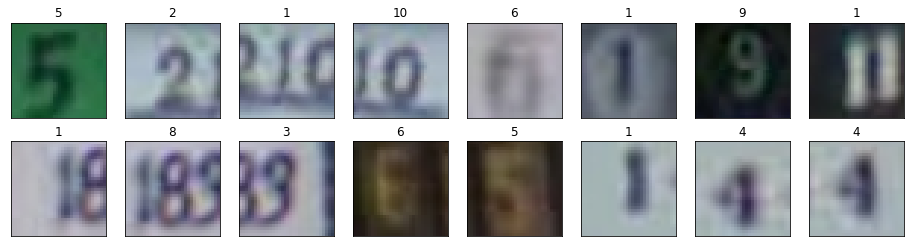

In [69]:
# Plot some test set images
plot_images(X_test, y_test, 2, 8)

To check unique labels

In [70]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


# Plotting Distribution of Data

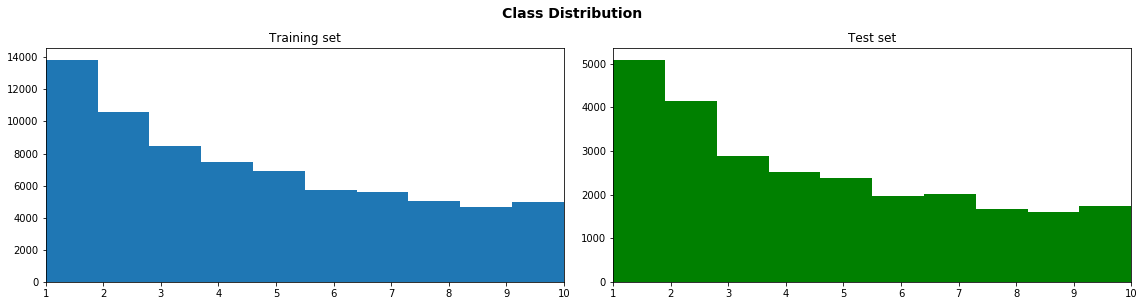

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()

All distributions have a positive skew, meaning that we have an underweight of higher values.

**Converting Label 10 -> 0**

In [0]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [73]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


# Splitting the Training to Train+Validation

In [0]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7, stratify = y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7)

# Visualize New distribution

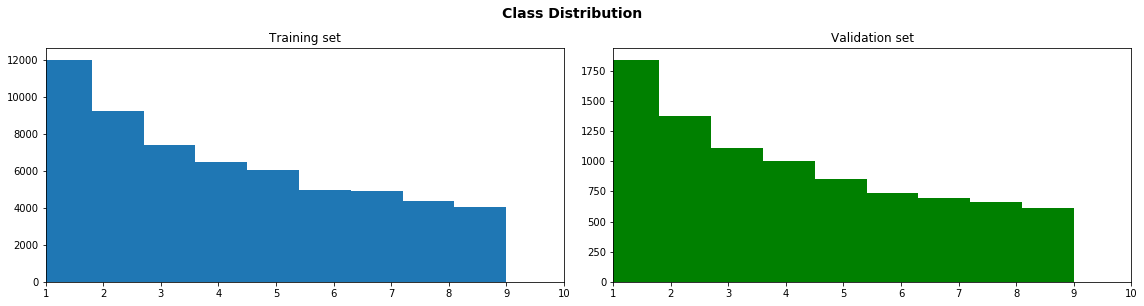

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_val, color='g', bins=10)
ax2.set_title("Validation set")

fig.tight_layout()

Data in each set

In [76]:
y_train.shape, y_val.shape, y_test.shape

((63733,), (9524,), (26032,))

Grayscale Conversion -To speed up our experiments we will convert our images from RGB to Grayscale, which grately reduces the amount of data we will have to process.

Y = 0.2990R + 0.5870G + 0.1140B

In [0]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

Converting to Float for numpy computation

In [0]:
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
val_greyscale = rgb2gray(X_val).astype(np.float32)

In [79]:
print("Training Set", train_greyscale.shape)
print("Validation Set", val_greyscale.shape)
print("Test Set", test_greyscale.shape)
print('')

Training Set (63733, 32, 32, 1)
Validation Set (9524, 32, 32, 1)
Test Set (26032, 32, 32, 1)



Removing RGB train, test, val set 
to reduce RAM Storage occupied by them

In [0]:
del X_train, X_test, X_val

Ploting the Grayscale Image

Before Normalization

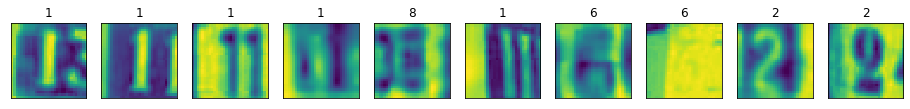

In [81]:
plot_images(train_greyscale, y_train, 1, 10)

Perform Normalization

In [0]:
# Calculate the mean on the training data
train_mean = np.mean(train_greyscale, axis=0)

# Calculate the std on the training data
train_std = np.std(train_greyscale, axis=0)

# Subtract it equally from all splits
train_greyscale_norm = (train_greyscale - train_mean) / train_std
test_greyscale_norm = (test_greyscale - train_mean)  / train_std
val_greyscale_norm = (val_greyscale - train_mean) / train_std

Plotting After Normalization

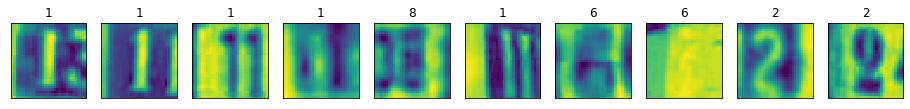

In [83]:
plot_images(train_greyscale_norm, y_train, 1, 10)

One Hot Label Encoding

Apply One Hot Encoding to make label
suitable for CNN Classification

In [84]:
from sklearn.preprocessing import OneHotEncoder
 
# Fit the OneHotEncoder
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()

print("Training set", y_train.shape)
print("Validation set", y_val.shape)
print("Test set", y_test.shape)

Training set (63733, 10)
Validation set (9524, 10)
Test set (26032, 10)


Storing Data to Disk

Stored only the Grayscale Data 
not the RGB

In [0]:
import h5py

# Create file
h5f = h5py.File('SVHN_grey.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=train_greyscale_norm)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=test_greyscale_norm)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=val_greyscale_norm)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

# CNN Model for SVHN Dataset 32 x 32 Images


Classifying SVHN dataset by using CNN

In [0]:
import os
import time
from __future__ import absolute_import
from __future__ import print_function
from datetime import timedelta
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) # Set default figure size

In [0]:
TENSORBOARD_SUMMARIES_DIR = '/content/svhn_classifier_logs'

Loading Data .....

In [88]:
# Open the file as readonly
h5f = h5py.File('SVHN_grey.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (63733, 32, 32, 1) (63733, 10)
Validation set (9524, 32, 32, 1) (9524, 10)
Test set (26032, 32, 32, 1) (26032, 10)


# Plotting n rows x m cols

Plot random images from passed data

In [0]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        
        # Annotate the image
        ax.set_title(title)
        
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

In [0]:
def prepare_log_dir():
    '''Clears the log files then creates new directories to place
        the tensorboard log file.''' 
        #TENSORBOARD_SUMMARIES_DIR = '/content/svhn_classifier_logs'
    if tf.gfile.Exists(TENSORBOARD_SUMMARIES_DIR):
        tf.gfile.DeleteRecursively(TENSORBOARD_SUMMARIES_DIR)
    tf.gfile.MakeDirs(TENSORBOARD_SUMMARIES_DIR)

# Get Batch Dynamically

In [0]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])

#Placeholder Variable

Using placeholder var whose value can directly
feed to the graph

In [0]:
comp = 32*32
tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 1], name='Input_Data')
y = tf.placeholder(tf.float32, shape = [None, 10], name='Input_Labels')
y_cls = tf.argmax(y, 1)

discard_rate = tf.placeholder(tf.float32, name='Discard_rate')
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'


Using Basic ConvNet Architecture

INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] -> DROPOUT -> [FC -> RELU] -> FC

In [0]:
def cnn_model_fn(features):
    """Model function for CNN."""
    
      # Input Layer
    input_layer = tf.reshape(features, [-1, 32, 32, 1], name='Reshaped_Input')

      # Convolutional Layer #1
    #with tf.name_scope('Conv1 Layer + ReLU'):
    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

      # Pooling Layer #1
    #with tf.name_scope('Pool1 Layer'):
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2 and Pooling Layer #2
    #with tf.name_scope('Conv2 Layer + ReLU'): 
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        
    #with tf.name_scope('Pool2 Layer'):
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
         inputs=dense, rate=discard_rate)

      # Logits Layer
    #with tf.name_scope('Logits Layer'):
    logits = tf.layers.dense(inputs=dropout, units=10)

    return logits

In [0]:
max_epochs = 2
num_examples = X_train.shape[0]

In [0]:
prepare_log_dir()

Prediction and Optimizer
Loss calculated for each iteration using prediction
from "cnn_model_fn()" results

Optimizer used is  Adam Optimizer

In [0]:
#with tf.name_scope('Model Prediction'):
prediction = cnn_model_fn(x)
prediction_cls = tf.argmax(prediction, 1)
#with tf.name_scope('loss'):
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
   onehot_labels=y, logits=prediction))
    #tf.summary.scalar('loss', loss)
    
#with tf.name_scope('Adam Optimizer'):
optimizer = tf.train.AdamOptimizer().minimize(loss)

**Accuracy**


Calculate total prediction and also
cal accuracy of passed data

In [0]:
# Predicted class equals the true class of each image?
correct_prediction = tf.equal(prediction_cls, y_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
#merged_summary = tf.summary.merge_all()

Tensorflow Session

In [0]:
sess= tf.Session()
sess.run(tf.global_variables_initializer())

**Saver Object**


Used for storing and reterving variable pesent 
in graph

In [0]:
saver = tf.train.Saver()

save_dir = '/content/checkpnts/'

# Create directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, 'svhn_single_greyscale')

Restoring the variable

In [0]:
#saver.restore(sess=session, save_path=save_path)


Initialized Variable

In [0]:
## No of example in each batch for updating weights
batch_size = 512

#Discarding or fuse % of neurons in Train mode
discard_per = 0.7

In [103]:
#with tf.Session() as sess:
 #   sess.run(tf.global_variables_initializer())
    
## To calculate total time of training
train_loss = []
valid_loss = []
start_time = time.time()
for epoch in range(max_epochs):
    print ('Training .........')
    epoch_loss = 0
    print ()
    print ('Epoch ', epoch+1 , ': ........ \n')
    step = 0   
    
    ## Training epochs ....
    for (epoch_x , epoch_y) in get_batch(X_train, y_train, batch_size):
        _, train_accu, c = sess.run([optimizer, accuracy, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: discard_per})
        train_loss.append(c)
    
        if(step%40 == 0):
            print ("Step:", step, ".....", "\nMini-Batch Loss   : ", c)
            print('Mini-Batch Accuracy :' , train_accu*100.0, '%')

            ## Validating prediction and summaries
            accu = 0.0
            for (epoch_x , epoch_y) in get_batch(X_val, y_val, 512):                            
                correct, _c = sess.run([correct_prediction, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
                valid_loss.append(_c)
                accu+= np.sum(correct[correct == True])
            print('Validation Accuracy :' , accu*100.0/y_val.shape[0], '%')
            print ()
        step = step + 1


    print ('Epoch', epoch+1, 'completed out of ', max_epochs)

    
## Calculate net time
time_diff = time.time() - start_time

## Testing prediction and summaries
accu = 0.0
for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    accu+= np.sum(correct[correct == True])
print('Test Accuracy :' , accu*100.0/y_test.shape[0], '%')
print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
print ()

Training .........

Epoch  1 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  2.3198335
Mini-Batch Accuracy : 8.984375 %
Validation Accuracy : 19.361612767744646 %

Step: 40 ..... 
Mini-Batch Loss   :  1.5533481
Mini-Batch Accuracy : 51.3671875 %
Validation Accuracy : 55.848383032339356 %

Step: 80 ..... 
Mini-Batch Loss   :  0.71922314
Mini-Batch Accuracy : 75.5859375 %
Validation Accuracy : 79.72490550188996 %

Step: 120 ..... 
Mini-Batch Loss   :  0.5547639
Mini-Batch Accuracy : 83.984375 %
Validation Accuracy : 84.28181436371273 %

Epoch 1 completed out of  2
Training .........

Epoch  2 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  0.56520444
Mini-Batch Accuracy : 84.765625 %
Validation Accuracy : 84.22931541369172 %

Step: 40 ..... 
Mini-Batch Loss   :  0.5534141
Mini-Batch Accuracy : 84.765625 %
Validation Accuracy : 85.40529189416212 %

Step: 80 ..... 
Mini-Batch Loss   :  0.45295694
Mini-Batch Accuracy : 85.7421875 %
Validation Accuracy : 86.8857622847543 %

Step: 120 .....

In [104]:

"""accu = 0.0
for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    predcls, classy = sess.run([prediction_cls, y_cls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    accumulate = np.sum((predcls == classy)*1)
    crct = np.sum(correct[correct == True])
    deaccumulate = np.sum((predcls != classy)*1)
    accu+= accumulate
    print('Test Accuracy :' , accumulate, crct, deaccumulate, accumulate+ deaccumulate, y_test.shape[0], '%')
print ()
"""

"accu = 0.0\nfor (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):\n    correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})\n    predcls, classy = sess.run([prediction_cls, y_cls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})\n    accumulate = np.sum((predcls == classy)*1)\n    crct = np.sum(correct[correct == True])\n    deaccumulate = np.sum((predcls != classy)*1)\n    accu+= accumulate\n    print('Test Accuracy :' , accumulate, crct, deaccumulate, accumulate+ deaccumulate, y_test.shape[0], '%')\nprint ()\n"


To save the model Checkpoints

In [105]:
saver.save(sess=sess, save_path=save_path)

'/content/checkpnts/svhn_single_greyscale'

**Model Visualization**
Plot different confusion map and images

to get insights of how our model is performing

**Plotting Train Actual Images**
Plot 3 rows x 6 col images randomly
with their true labels

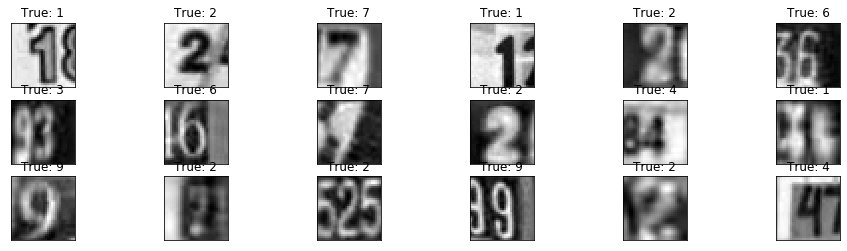

In [106]:
plot_images(X_train, 3, 6, y_train);

Evaluate predicted class from test data

In [107]:
test_pred = []
for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([prediction_cls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    test_pred.append((np.asarray(correct, dtype=int)).T)

print ('Completed')

Completed


Convert Lists of List to numpy array
compatiable with y_label

In [0]:
def flatten(lists):
    results = []
    for numbers in lists:
        for x in numbers:
            results.append(x)
    return np.asarray(results)

In [0]:
flat_array = flatten(test_pred)
flat_array = (flat_array.T)
flat_array = flat_array[0]

In [110]:
flat_array.shape

(26032,)

Confusion Metric

Plot and see the misclassfied results of model

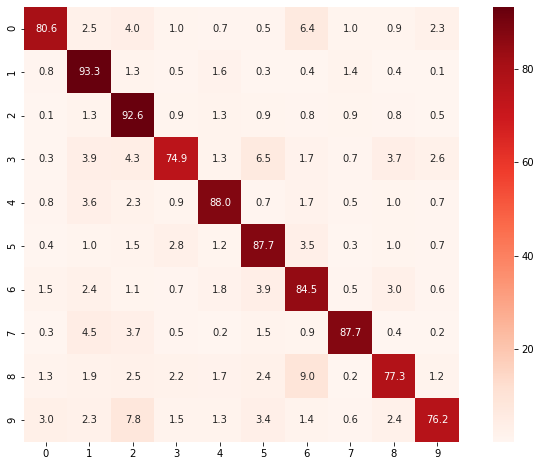

In [111]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=flat_array)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

**Plotting Misclassified results**

Plot the misclassfied images of randomly sampled
from test set

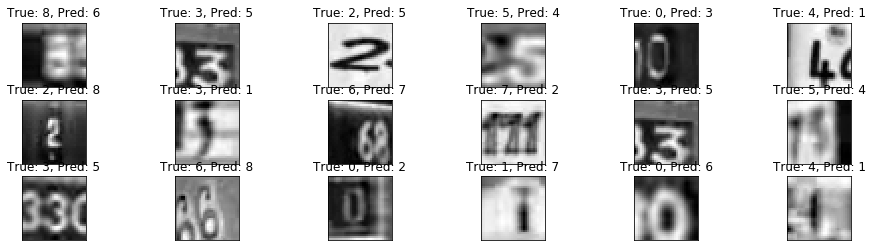

In [112]:
# Find the incorrectly classified examples
incorrect = flat_array != np.argmax(y_test, axis=1)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = flat_array[incorrect]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

**Plotting Correctly classified results**
Plot the correctly classfied images of randomly sampled
from test set

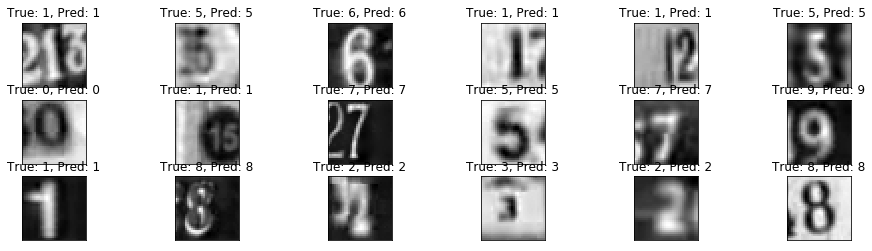

In [113]:
# Find the incorrectly classified examples
correct = np.invert(incorrect)

# Select the correctly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = flat_array[correct]

# Plot the mis-classified examples
plot_images(images, 3, 6, cls_true, cls_pred);

**Plotting Validation and Training Losses**

Plotting the losses to gurantee that model
is learning good or not

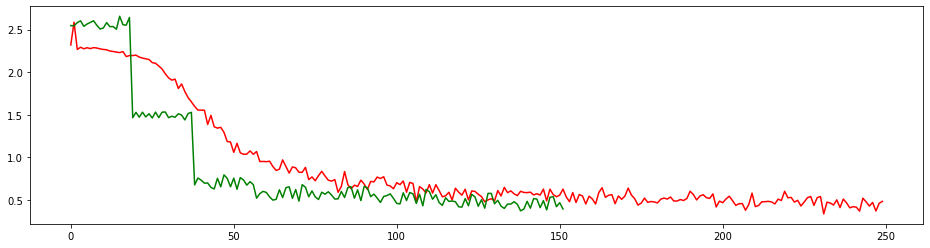

In [114]:
import matplotlib.pyplot as plt
plt.plot(train_loss ,'r')
plt.plot(valid_loss, 'g')